In [1]:
###########################################################
#
# Sequential Minimal Optimisation ( SMO ) - Kernel Dual SVR
#
############################################################
#
# Dual SVR - min 0.5 * sum(sum((alpha_i - alpha_i*) * (alpha_j - alpha_j*) * K(x_i, x_j), j=1 to n), i=1 to n)
#            + epsilon * sum(alpha_i + alpha_i*, i=1 to n) + sum((alpha_i - alpha_i*) * y_i, i=1 to n)

# subject to:
# 0 <= alpha_i <= C  for all i
# 0 <= alpha_i* <= C  for all i
# sum(alpha_i - alpha_i*, i=1 to n) = 0
# SMO exists to solve this efficiently - which works by updating two Lagrange multiplier pairs at the same time
# Previous way of updating one alpha at a time broke the sum(alpha_i - alpha_i*) = 0 condition
# Now we update (alpha_i - alpha_i*) and choose another (alpha_j - alpha_j*) to compensate the change
# (alpha_i - alpha_i*) + (alpha_j - alpha_j*) = constant ( both constrained to [-C,C])
# E_i = f(x_i) - y_i
# f(x) = sum((alpha_k - alpha_k*) * K(x_k, x), k) + b
# Maximizing the 1D quadratic gives us the new (alpha_j - alpha_j*) value which we clip to [L,H]
# Calculate new (alpha_i - alpha_i*) from (alpha_j - alpha_j*)
# Decompose into alpha and alpha* using max(0, delta) and max(0, -delta)
# Similarly new b is obtained based on epsilon-insensitive tube
# Checking function is KKT with epsilon-insensitive loss


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def linear_kernel(x,z):
    return (np.dot(x,z))

def polynomial_kernel(x,z,degree=2,coeff=1.0):
    return (np.dot(x,z)+coeff)**degree

def rbf_kernel(x,z,sigma=1.0):
    return np.exp(-np.linalg.norm(x-z)**2/(2*sigma**2))

def kernel_matrix(X,kernel):
    n=X.shape[0]
    K=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel(X[i],X[j])
    return K

def dual_svr_smo(X,Y,kernel,C=1.0,epsilon=0.1,tol=1e-3,m_cycles=20000):
    
    n_samples,n_features = X.shape
    alpha = np.zeros(n_samples)
    alpha_s = np.zeros(n_samples)
    b = 0.0
    K = kernel_matrix(X,kernel)
    
    def error(i):
        return np.dot(alpha-alpha_s,K[:,i]) + b - Y[i]
    
    def violating_kkt(i,E_i):
        return (E_i < -epsilon-tol and alpha[i] < C) or (E_i > epsilon+tol and alpha_s[i] < C)
    
    cycles = 0
    while cycles<m_cycles:
        n_changed = 0
        
        for i in range(n_samples):
            E_i = error(i)
            if not violating_kkt(i,E_i):
                continue
            
            errors = np.array([error(k) for k in range(n_samples)])
            error_diffs = np.abs(errors - E_i)
            error_diffs[i] = -np.inf
            j = np.argmax(error_diffs)
            E_j = errors[j]
            old_di = alpha[i] - alpha_s[i]
            old_dj = alpha[j] - alpha_s[j]
            
            total_delta = old_di + old_dj
            L = max(-C, total_delta - C)
            H = min(C, total_delta + C)
            
            if L == H:
                continue
            eta = K[i, i] + K[j, j] - 2 * K[i, j]
            if eta <= 0:
                continue
            
            new_dj = old_dj + (E_i - E_j) / eta
            new_dj = np.clip(new_dj, L, H)
            new_di = total_delta - new_dj
            
            if abs(new_dj - old_dj) < 1e-5:
                continue
            
            alpha[i] = max(0, new_di)
            alpha_s[i] = max(0, -new_di)
            alpha[j] = max(0, new_dj)
            alpha_s[j] = max(0, -new_dj)
            
            eps_shift_i = epsilon if new_di > 0 else (-epsilon if new_di < 0 else 0)
            eps_shift_j = epsilon if new_dj > 0 else (-epsilon if new_dj < 0 else 0)
            
            b1 = b - E_i - eps_shift_i - K[i, i] * (new_di - old_di) - K[i, j] * (new_dj - old_dj)
            b2 = b - E_j - eps_shift_j - K[i, j] * (new_di - old_di) - K[j, j] * (new_dj - old_dj)
            
            if 0 < alpha[i] < C or 0 < alpha_s[i] < C:
                b = b1
            elif 0 < alpha[j] < C or 0 < alpha_s[j] < C:
                b = b2
            else:
                b = (b1 + b2) / 2
            
            n_changed += 1
        
        if n_changed == 0:
            cycles += 1
        else:
            cycles = 0
    
    return alpha, alpha_s, b

def decision_function(X_train,alpha,alpha_s,b,kernel,x):
    diff = alpha - alpha_s
    sv_idx = np.abs(diff) > 1e-7
    if not np.any(sv_idx):
        return b
    return np.sum(diff[sv_idx] * np.array([kernel(xi,x) for xi in X_train[sv_idx]])) + b

================= LINEAR SVR ====================

b : -0.1200
alpha : [0.         0.         0.95866667 0.175      0.         0.05
 0.         0.07551701]
alpha_s : [0.21235828 1.         0.         0.         0.         0.
 0.0468254  0.        ]
predictions : [ 1.82  3.76  5.7   7.64  9.58 11.52 13.46 15.4 ]
errors : [-0.28 -0.14 -0.5  -0.46 -0.22 -0.58 -0.54 -0.5 ]


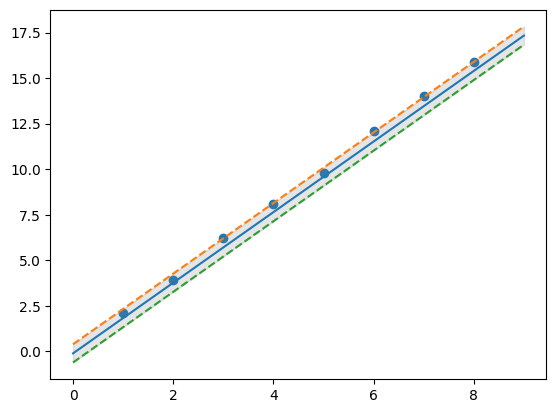

In [16]:
X = np.array([
    [1.0], [2.0], [3.0], [4.0], [5.0], [6.0], [7.0], [8.0]
])

Y = np.array([2.1, 3.9, 6.2, 8.1, 9.8, 12.1, 14.0, 15.9])
epsilon=0.5
print("================= LINEAR SVR ====================\n")
alpha, alpha_s, b = dual_svr_smo(X, Y, linear_kernel, C=1.0, epsilon=0.5)
predictions = np.array([decision_function(X, alpha, alpha_s, b, linear_kernel, X[i]) for i in range(len(X))])
errors = predictions - Y
print(f"b : {b:.4f}")
print(f"alpha : {alpha}")
print(f"alpha_s : {alpha_s}")
print(f"predictions : {predictions}")
print(f"errors : {errors}")

plt.scatter(X, Y)
X_plot = np.linspace(min(X)-1, max(X)+1, 100).reshape(-1, 1)
y_plot = np.array([decision_function(X, alpha, alpha_s, b, linear_kernel, x) for x in X_plot])
plt.plot(X_plot, y_plot)
plt.fill_between(X_plot.flatten(), y_plot-epsilon, y_plot+epsilon, color='gray', alpha=0.2)
plt.plot(X_plot, y_plot+epsilon, '--')
plt.plot(X_plot, y_plot-epsilon, '--')
plt.show()


================= RBF SVR ====================

b : 13.9250
alpha : [ 0.  0.  0.  0. 10.]
alpha_s : [10.  0.  0.  0.  0.]
Actual Y    : [ 3.4   6.17 10.83 17.1  24.45]
Predicted Y : [ 3.92835463  7.97078337 13.925      19.87921663 23.92164537]
Errors      : [0.52835463 1.80078337 3.095      2.77921663 0.52835463]


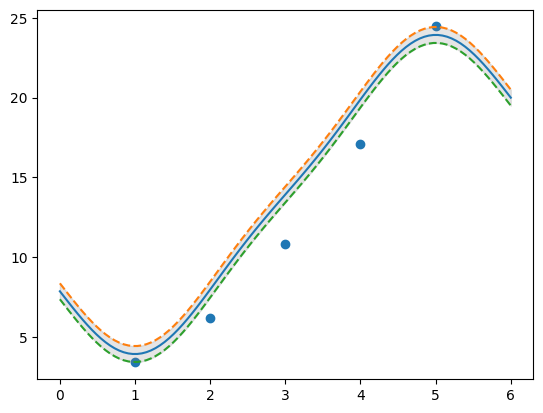

In [15]:
# In rbf the sigma is like the spotlight width of a point -> rbf works in base at local level imagine creating bumpps for each point large sigma would say these bumps have more influence over a wider area and overlap -> smoother function
# whereas for smaller sigma it would be more bumpy but locally accurate

X = np.array([[1.0], [2.0], [3.0], [4.0], [5.0]])
Y= np.array([3.4, 6.17, 10.83, 17.1, 24.45])

C = 10.0
epsilon = 0.5

print("\n================= RBF SVR ====================\n")
alpha, alpha_s, b = dual_svr_smo(X, Y, rbf_kernel, C=C, epsilon=epsilon)
predictions = np.array([decision_function(X, alpha, alpha_s, b, rbf_kernel, X[i]) for i in range(len(X))])
errors = np.abs(predictions - Y)

print(f"b : {b:.4f}")
print(f"alpha : {alpha}")
print(f"alpha_s : {alpha_s}")
print(f"Actual Y    : {Y}")
print(f"Predicted Y : {predictions}")
print(f"Errors      : {errors}")

plt.scatter(X, Y)
X_plot = np.linspace(min(X)-1, max(X)+1, 100).reshape(-1, 1)
y_plot = np.array([decision_function(X, alpha, alpha_s, b, rbf_kernel, x) for x in X_plot])
plt.plot(X_plot, y_plot)
plt.fill_between(X_plot.flatten(), y_plot-epsilon, y_plot+epsilon, color='gray', alpha=0.2)
plt.plot(X_plot, y_plot+epsilon, '--')
plt.plot(X_plot, y_plot-epsilon, '--')
plt.show()


================= RBF SVR ====================

b : 2.7921
alpha : [0.         0.         0.         0.         0.03462171]
alpha_s : [0.03462171 0.         0.         0.         0.        ]
Actual Y    : [ 3.4   6.17 10.83 17.1  24.45]
Predicted Y : [ 3.9         6.66973684 11.10131579 17.19473684 24.95      ]
Errors      : [0.5        0.49973684 0.27131579 0.09473684 0.5       ]


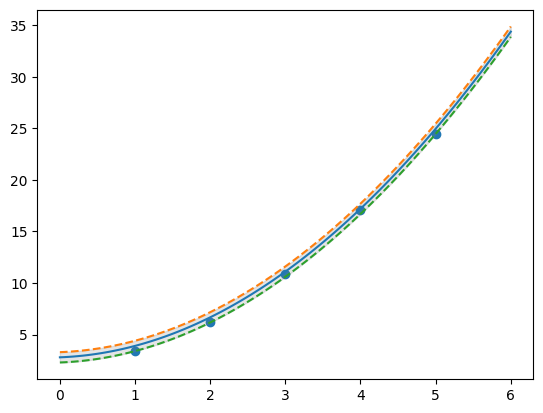

In [12]:
X = np.array([[1.0], [2.0], [3.0], [4.0], [5.0]])
Y_reg = np.array([3.4, 6.17, 10.83, 17.1, 24.45])

C = 10.0
epsilon = 0.5

print("\n================= RBF SVR ====================\n")
alpha, alpha_s, b = dual_svr_smo(X, Y, polynomial_kernel, C=C, epsilon=epsilon)
predictions = np.array([decision_function(X, alpha, alpha_s, b, polynomial_kernel, X[i]) for i in range(len(X))])
errors = np.abs(predictions - Y)

print(f"b : {b:.4f}")
print(f"alpha : {alpha}")
print(f"alpha_s : {alpha_s}")
print(f"Actual Y    : {Y}")
print(f"Predicted Y : {predictions}")
print(f"Errors      : {errors}")

plt.scatter(X, Y)
X_plot = np.linspace(min(X)-1, max(X)+1, 100).reshape(-1, 1)
y_plot = np.array([decision_function(X, alpha, alpha_s, b, polynomial_kernel, x) for x in X_plot])
plt.plot(X_plot, y_plot)
plt.fill_between(X_plot.flatten(), y_plot-epsilon, y_plot+epsilon, color='gray', alpha=0.2)
plt.plot(X_plot, y_plot+epsilon, '--')
plt.plot(X_plot, y_plot-epsilon, '--')
plt.show()